In [1]:
## Make width of notebook 90%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
from datasets import data as Local ## Local module to get dataframes

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [3]:
games_df, winners_df, greater_fgp_df, greater_fg3_df, greater_ft_df, greater_ast_df, greater_reb_df, cumulative_stats_df, games_details_df, teams_df, players_df, ranking_df = \
    Local.get_all_dataset_dataframes('../../datasets/')

Home team has winrate of 59.1%

# Remove non-data

In [4]:
cumulative_stats_copy_df = cumulative_stats_df.copy()

# Remove rows where games_played==0
cumulative_stats_copy_df = cumulative_stats_copy_df.loc[(cumulative_stats_copy_df['GAMES_PLAYED_home']>0) & cumulative_stats_copy_df['GAMES_PLAYED_away']>0]

for key in ['DATE','GAME_ID','TEAM_ID_home','TEAM_ID_away','SEASON_TYPE','SEASON','GAMES_PLAYED_home','GAMES_PLAYED_away']:
    del cumulative_stats_copy_df[key]
# Only look at home teams
# cumulative_stats_copy_df = cumulative_stats_copy_df.loc[cumulative_stats_copy_df['AT_HOME']==True]
# del cumulative_stats_copy_df['AT_HOME']

# Add hometeam win/loss column
cumulative_stats_copy_df['HOME_WIN'] = winners_df
cumulative_stats_copy_df['HOME_HIGHER_FG_PCT'] = greater_fgp_df
cumulative_stats_copy_df['HOME_HIGHER_FG3_PCT'] = greater_fg3_df
cumulative_stats_copy_df['HOME_HIGHER_FT_PCT'] = greater_ft_df
cumulative_stats_copy_df['HOME_HIGHER_AST'] = greater_ast_df
cumulative_stats_copy_df['HOME_HIGHER_REB'] = greater_reb_df

cumulative_stats_copy_df

,PPG_total_home,FG_PCT_total_home,FG3_PCT_total_home,FT_PCT_total_home,APG_total_home,RPG_total_home,PPG_total_away,FG_PCT_total_away,FG3_PCT_total_away,FT_PCT_total_away,APG_total_away,RPG_total_away,W_PCT_away,W_PCT_home,HOME_WIN,HOME_HIGHER_FG_PCT,HOME_HIGHER_FG3_PCT,HOME_HIGHER_FT_PCT,HOME_HIGHER_AST,HOME_HIGHER_REB
19,104.000000,0.527000,0.429000,0.657000,22.000000,33.000000,101.000000,0.467000,0.444000,0.871000,19.000000,39.000000,1.000000,1.000000,0,0,0,1,0,0
21,86.000000,0.380000,0.188000,0.852000,19.000000,37.000000,101.000000,0.464000,0.250000,0.679000,22.000000,47.000000,1.000000,0.000000,0,0,0,1,1,0
22,86.000000,0.352000,0.222000,0.647000,15.000000,55.000000,80.000000,0.350000,0.429000,0.750000,18.000000,45.000000,0.000000,1.000000,1,1,0,1,1,0
23,58.000000,0.457000,0.667000,0.700000,10.000000,31.000000,89.000000,0.462000,0.214000,0.538000,21.000000,36.000000,0.000000,0.000000,1,1,1,1,0,1
24,87.500000,0.432000,0.420000,0.672000,20.500000,43.000000,79.000000,0.329000,0.143000,0.897000,7.000000,44.000000,0.000000,0.500000,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23515,111.500000,0.443500,0.353000,0.691000,25.000000,41.500000,92.000000,0.427000,0.283000,0.818000,26.000000,35.000000,0.000000,1.000000,1,1,1,1,1,1
23516,105.000000,0.438000,0.383000,0.619000,26.000000,35.500000,108.000000,0.471000,0.241000,0.750000,23.000000,42.000000,1.000000,0.000000,0,0,1,1,1,0
23517,119.333333,0.466667,0.329333,0.704667,30.666667,52.666667,111.333333,0.392667,0.332333,0.789667,24.000000,56.000000,0.333333,1.000000,1,1,0,1,1,1
23518,100.000000,0.415000,0.321500,0.704500,22.000000,44.500000,93.333333,0.413333,0.333000,0.713000,20.000000,41.666667,0.666667,0.000000,1,0,0,1,1,0


In [5]:
standardized_stats_data_df = pd.DataFrame(StandardScaler().fit_transform(cumulative_stats_copy_df), columns=cumulative_stats_copy_df.columns)

# Covariance Matrix

In [6]:
standardized_stats_data_df.cov().style.background_gradient(cmap='rainbow',axis=None)

,PPG_total_home,FG_PCT_total_home,FG3_PCT_total_home,FT_PCT_total_home,APG_total_home,RPG_total_home,PPG_total_away,FG_PCT_total_away,FG3_PCT_total_away,FT_PCT_total_away,APG_total_away,RPG_total_away,W_PCT_away,W_PCT_home,HOME_WIN,HOME_HIGHER_FG_PCT,HOME_HIGHER_FG3_PCT,HOME_HIGHER_FT_PCT,HOME_HIGHER_AST,HOME_HIGHER_REB
PPG_total_home,1.000086,0.577930,0.320850,0.262315,0.642368,0.450241,0.509648,0.171007,0.077982,0.172839,0.308653,0.274147,0.003393,0.366781,0.020550,0.008949,0.016030,0.011091,-0.013923,-0.002707
FG_PCT_total_home,0.577930,1.000086,0.471234,0.141131,0.552130,-0.038760,0.164732,0.151080,0.075411,0.106149,0.090591,-0.023496,-0.000063,0.529228,0.016877,0.009226,0.011525,0.000911,-0.012417,-0.004362
FG3_PCT_total_home,0.320850,0.471234,1.000086,0.153999,0.303430,-0.043142,0.079763,0.068984,0.022010,0.074419,0.039658,-0.002573,-0.011145,0.360784,0.018786,-0.000748,0.011750,0.010823,-0.002392,0.001264
FT_PCT_total_home,0.262315,0.141131,0.153999,1.000086,0.147327,0.018244,0.162725,0.097828,0.060711,0.083958,0.121447,0.067025,0.007031,0.123576,-0.013269,-0.002635,-0.005012,-0.010113,0.001341,-0.003490
APG_total_home,0.642368,0.552130,0.303430,0.147327,1.000086,0.259687,0.301199,0.092882,0.049023,0.121493,0.204079,0.186842,0.001330,0.351580,0.011401,-0.000758,0.012796,0.010123,-0.008681,-0.008690
RPG_total_home,0.450241,-0.038760,-0.043142,0.018244,0.259687,1.000086,0.290462,-0.012821,0.003172,0.081828,0.207781,0.270108,-0.012216,0.213603,0.003356,0.001282,0.016163,0.011846,-0.002348,-0.004373
PPG_total_away,0.509648,0.164732,0.079763,0.162725,0.301199,0.290462,1.000086,0.581007,0.304723,0.267160,0.636606,0.445122,0.359938,-0.002388,0.009635,0.005296,0.011194,-0.001907,-0.015381,-0.003100
FG_PCT_total_away,0.171007,0.151080,0.068984,0.097828,0.092882,-0.012821,0.581007,1.000086,0.446872,0.131685,0.543213,-0.047935,0.512279,0.002840,0.012601,0.008782,0.002568,-0.015214,0.002847,0.004439
FG3_PCT_total_away,0.077982,0.075411,0.022010,0.060711,0.049023,0.003172,0.304723,0.446872,1.000086,0.143724,0.286749,-0.049987,0.352072,-0.006447,0.009432,0.016033,0.016325,-0.005999,-0.000049,0.005681
FT_PCT_total_away,0.172839,0.106149,0.074419,0.083958,0.121493,0.081828,0.267160,0.131685,0.143724,1.000086,0.134085,-0.009458,0.103002,0.005807,0.005283,0.002073,-0.002401,-0.003866,-0.002479,0.005527


# Scatter Matrix

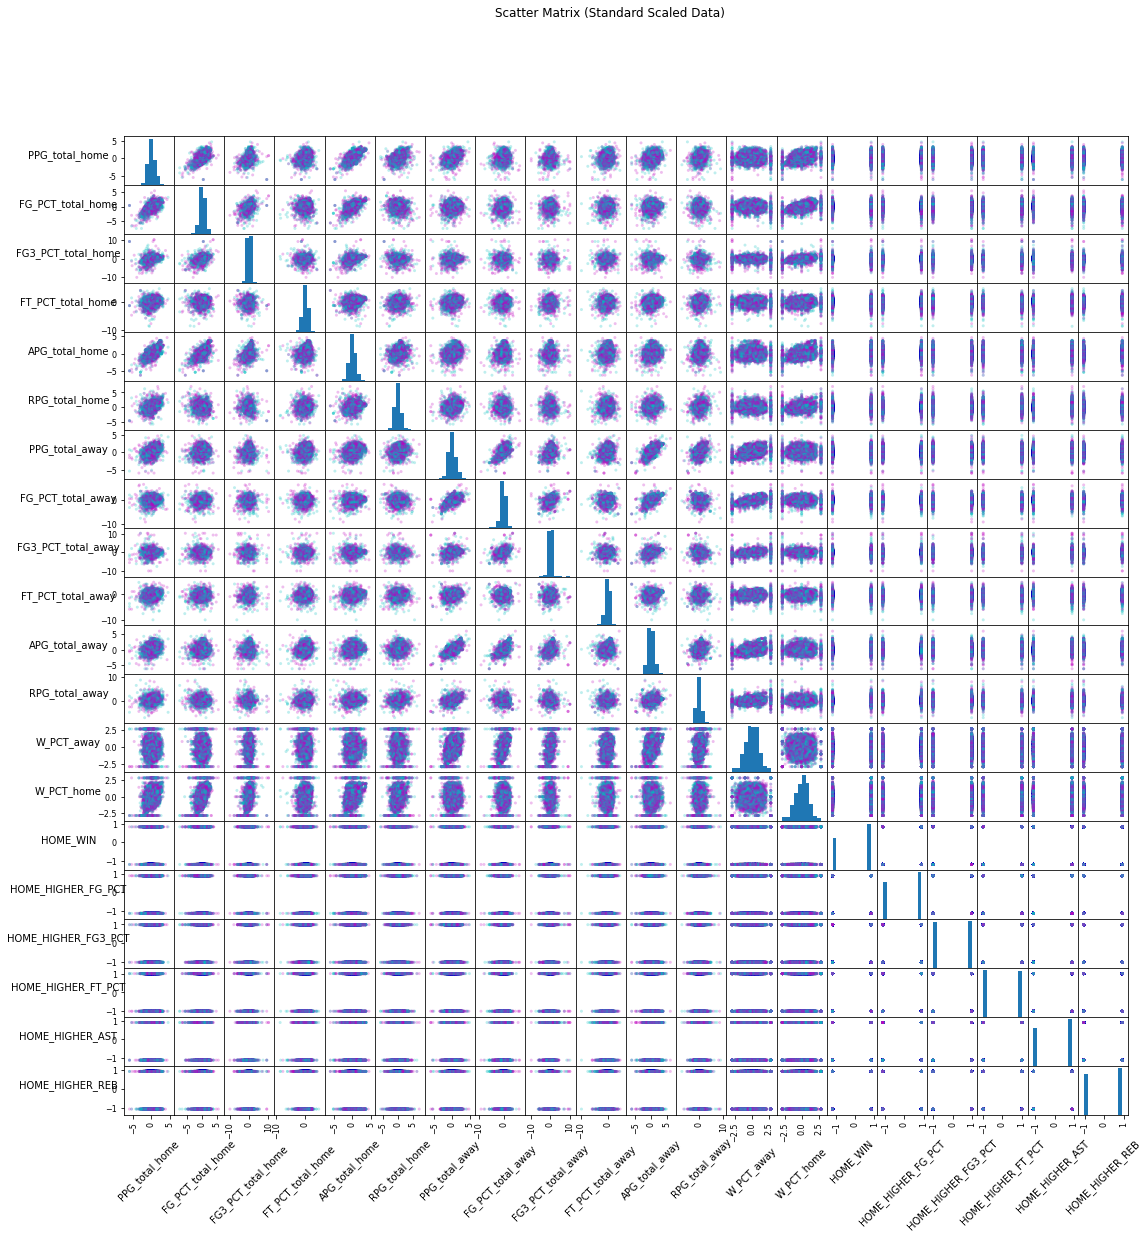

In [8]:
sm=pd.plotting.scatter_matrix(
    standardized_stats_data_df,
    alpha=0.25,
    figsize=(18,18),
    diagonal='hist',
    range_padding=0.3, # More padding to fit labels
    c=['c','m']*(len(standardized_stats_data_df)//2)+['c'], # Color differentiate points from different data
)
# Rotate & reposition labels
# (referenced https://stackoverflow.com/questions/32560932/how-to-customize-a-scatter-matrix-to-see-all-titles)
for s in sm.reshape(-1):
    s.xaxis.label.set_rotation(45)
    s.yaxis.label.set_rotation(0)
    s.get_yaxis().set_label_coords(-1.1,0.5)
plt.suptitle('Scatter Matrix (Standard Scaled Data)')
plt.show()

# Train test split 80/20

In [9]:
cumulative_stats_data_df = cumulative_stats_df.copy()

for key in ['DATE','GAME_ID','TEAM_ID_home','TEAM_ID_away','SEASON_TYPE','SEASON','GAMES_PLAYED_home','GAMES_PLAYED_away']:
    del cumulative_stats_data_df[key]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    cumulative_stats_data_df,
    winners_df,
    train_size=0.8,
    random_state=0,
)

# Train KMeans

In [11]:
kmeans_model = KMeans(n_clusters=2, random_state=0).fit(X_train)

In [12]:
# kmeans_model.score(X_test, y_test)

In [13]:
correct_df = pd.Series([x==y for x,y in zip(kmeans_model.predict(X_test), y_test)])
len(correct_df.loc[correct_df==True])/len(correct_df)

0.4147534013605442

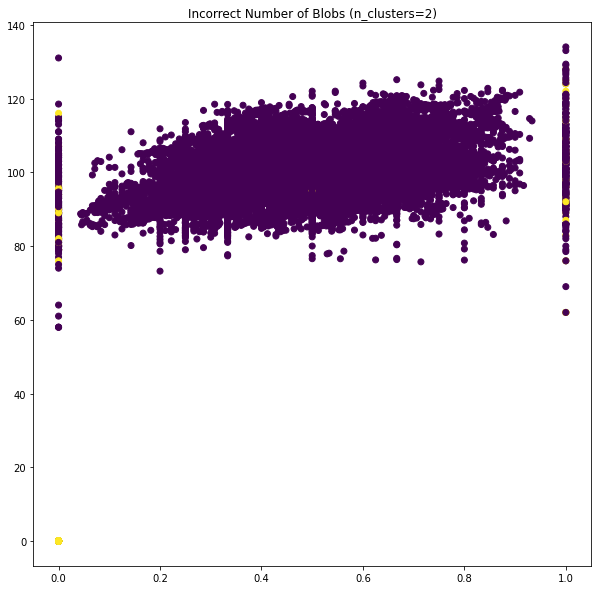

In [14]:
plt.figure(figsize=(10, 10))
plt.scatter(cumulative_stats_data_df['W_PCT_away'], cumulative_stats_data_df['PPG_total_away'], c=kmeans_model.predict(cumulative_stats_data_df))
plt.title(f"Incorrect Number of Blobs (n_clusters={2})")

plt.show()

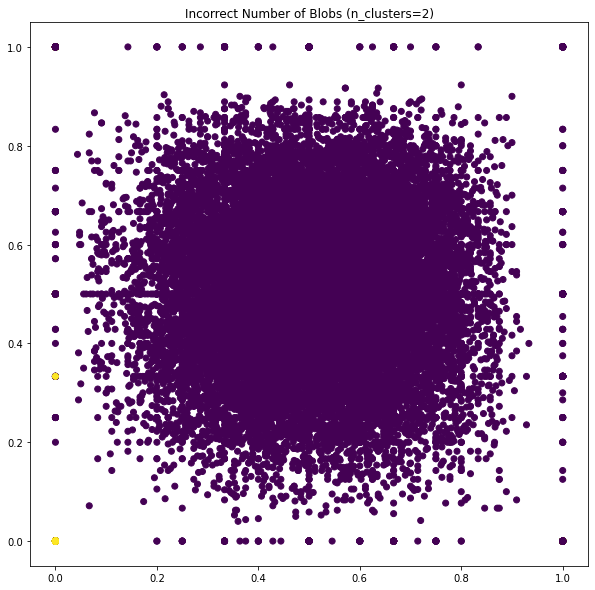

In [15]:
plt.figure(figsize=(10, 10))
plt.scatter(cumulative_stats_data_df['W_PCT_away'], cumulative_stats_data_df['W_PCT_home'], c=kmeans_model.predict(cumulative_stats_data_df))
plt.title(f"Incorrect Number of Blobs (n_clusters={2})")

plt.show()

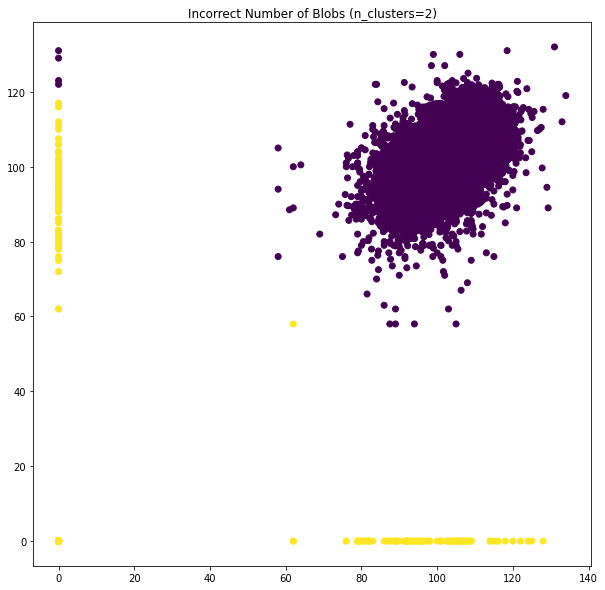

In [16]:
plt.figure(figsize=(10, 10))
plt.scatter(cumulative_stats_data_df['PPG_total_away'], cumulative_stats_data_df['PPG_total_home'], c=kmeans_model.predict(cumulative_stats_data_df))
plt.title(f"Incorrect Number of Blobs (n_clusters={2})")

plt.show()